In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

# Task 1 (Cross Validation)

The Shape of the Data is (1797, 64)


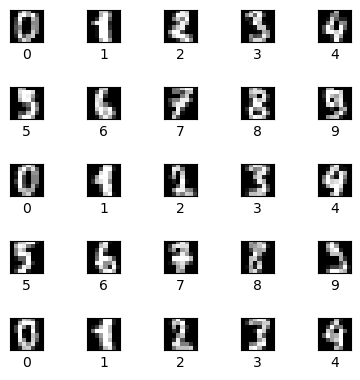

In [2]:

digits = datasets.load_digits ()
print(f"The Shape of the Data is {digits.data.shape}")
# Plot the digits to get an overview
fig, axes = plt.subplots(5, 5, figsize=(4, 4))
# add some space between the plots
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set(xticks=[], yticks=[], xlabel=digits.target[i])
plt.show()


## Split the data Set into 5 equally large folds

then train 5 models and compute the accuracy


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

all_features = digits.data
all_targets = digits.target

# cut of at 1795
features = all_features[:1795].copy()
targets = all_targets[:1795].copy()

# split into 5 folds
features_folds = np.array_split(features, 5)
targets_folds = np.array_split(targets, 5)

accuracies = []
for i in range(5):
    X_test = features_folds[i]
    y_test = targets_folds[i]
    
    X_train = []
    y_train = []
    for j in range(5):
        if j == i:
            continue
        X_train.extend(features_folds[j])
        y_train.extend(targets_folds[j])
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    model = SVC(kernel='rbf', gamma=0.01)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {round(mean_accuracy, 3)}")

Mean Accuracy: 0.709


## Task 1.2 Use entire dataset

- Use train_test_split to split the data into training and testing sets
- Use KFold to split training Set into 5 folds
- Train 5 models for each gamma in gamma_space
- Compute the mean accuracy for each gamma
- Select the best gamma and train a final model
- Compare the final accuracy with the mean accuracy from the folds


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Split the data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(digits.data,
                                                      digits.target,
                                                      test_size=0.2, 
                                                      random_state=42)
# Further split the training set into 5 folds
kf = KFold(n_splits=5)
gamma_space = np.logspace(-1, -5, 9)
best_gamma = None
best_accuracy = 0

for gamma in gamma_space:
    accuracies = []
    for train_index, val_index in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_index], X_train_full[val_index]
        y_train, y_val = y_train_full[train_index], y_train_full[val_index]

        model = SVC(kernel='rbf', gamma=gamma)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy) 
        
    mean_accuracy = np.mean(accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_gamma = gamma
        
print(f"Best Gamma: {best_gamma} with Mean Accuracy: {round(best_accuracy, 3)}")

final_model = SVC(kernel='rbf', gamma=best_gamma)
final_model.fit(X_train_full, y_train_full)

final_y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)
print(f"Final Accuracy on Test Set: {round(final_accuracy, 3)}")


Best Gamma: 0.001 with Mean Accuracy: 0.989
Final Accuracy on Test Set: 0.989


## Task 1.4 Zoom in on the best gammasa

In [5]:
from sklearn.model_selection import LeaveOneOut
from joblib import Parallel, delayed
import numpy as np

def evaluate_gamma(gamma, X_train_full, y_train_full):
    accuracies = []
    for train_index, test_index in LeaveOneOut().split(X_train_full):
        X_train, X_test = X_train_full[train_index], X_train_full[test_index]
        y_train, y_test = y_train_full[train_index], y_train_full[test_index]
        
        model = SVC(kernel='rbf', gamma=gamma)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return np.mean(accuracies)

gamma_space = np.linspace(5.0e-4,1.0e-3,6)

# Parallel processing of different gamma values
accuracies = Parallel(n_jobs=-1)(
    delayed(evaluate_gamma)(gamma, X_train_full, y_train_full) 
    for gamma in gamma_space
)

mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {round(mean_accuracy, 3)}")

best_gamma = gamma_space[np.argmax(accuracies)]
print(f"Best Gamma: {best_gamma} with Mean Accuracy: {round(mean_accuracy, 3)}")

# Use the best gamma to train a final model and compute the accuracy on the test set
final_model = SVC(kernel='rbf', gamma=best_gamma)
final_model.fit(X_train_full, y_train_full)
final_y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)
print(f"Final Accuracy on Test Set: {round(final_accuracy, 3)}")


Mean Accuracy: 0.991
Best Gamma: 0.0007 with Mean Accuracy: 0.991
Final Accuracy on Test Set: 0.989


## Task 1.5 Use GridSearchCV with KernelRidge to scan the parameter space


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error

parameters = {'gamma':[1.e-3, 7.5e-4, 5.e-4, 2.5e-4],
              'alpha':[1.e-4, 1.e-3, 1.e-2, 1.e-1]}

grid_search = GridSearchCV(estimator=KernelRidge(),
                            param_grid=parameters, 
                            scoring='neg_mean_squared_error')

grid_search.fit(X_train_full, y_train_full)

# Print the best
print(grid_search.best_params_)

# get R2 score
print(f"R2 Score: {np.round(grid_search.score(X_test, y_test), 3)}")
# get MAE
print(f"MAE: {np.round(mean_absolute_error(y_test, grid_search.predict(X_test)), 3)}")



{'alpha': 0.0001, 'gamma': 0.001}
R2 Score: -3.305
MAE: 1.424


# Task 2 Combining Kernels


## Data preparation

Number of Years: 44


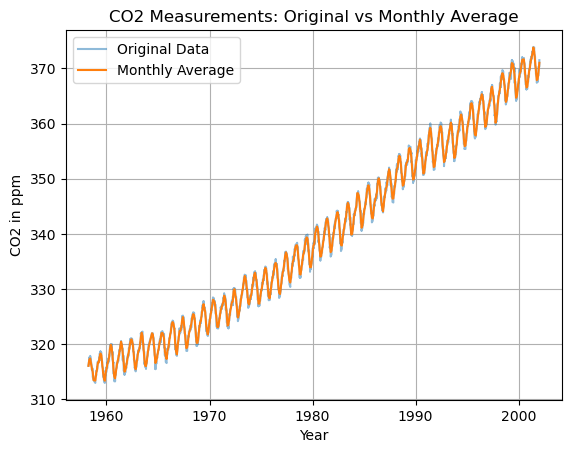

Shape of X: (521,)
Shape of y: (521,)


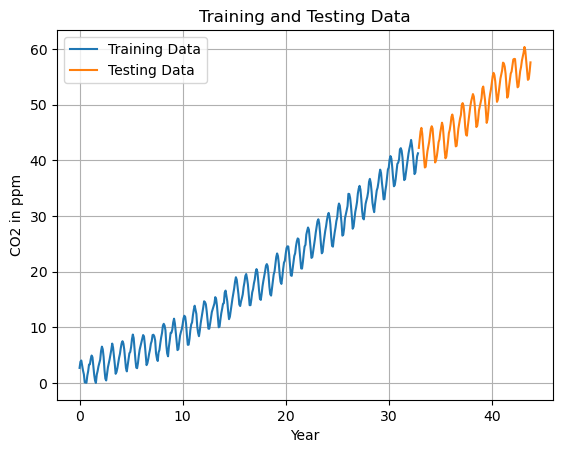

In [7]:
from sklearn.datasets import fetch_openml
import pandas as pd
co2 = fetch_openml(data_id =41187 , as_frame=True)
df = co2.frame

# How many years are in the data?
print(f"Number of Years: {df['year'].nunique()}")

# Compute averages over the same month
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['year_month'] = df['date'].dt.to_period('M')
df['year_month_float'] = df['year_month'].dt.year + df['year_month'].dt.month / 12
monthly_avg = df.groupby('year_month')[['co2', 'year_month_float']].mean().reset_index()

plt.plot(df['year_month_float'], df['co2'], label='Original Data', alpha=0.5)
plt.plot(monthly_avg['year_month_float'], monthly_avg['co2'], label='Monthly Average')
plt.legend()
plt.title('CO2 Measurements: Original vs Monthly Average')
plt.xlabel('Year')
plt.ylabel('CO2 in ppm')
plt.grid()
plt.show()

X = monthly_avg['year_month_float'].to_numpy()
y = monthly_avg['co2'].to_numpy()
# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
# subtract the minumum from X and y
X = X - X.min()
y = y - y.min()
# Make 75% of the data for training and 25% for testing
X_train = X[:int(0.75 * len(X))]
y_train = y[:int(0.75 * len(y))]
X_test = X[int(0.75 * len(X)):]
y_test = y[int(0.75 * len(y)):]

# Plot the training and testing data
plt.plot(X_train, y_train, label='Training Data')
plt.plot(X_test, y_test, label='Testing Data')
plt.xlabel('Year')
plt.ylabel('CO2 in ppm')
plt.title('Training and Testing Data')
plt.legend()
plt.grid()
plt.show()



## Task 2.4 What function best fits the data


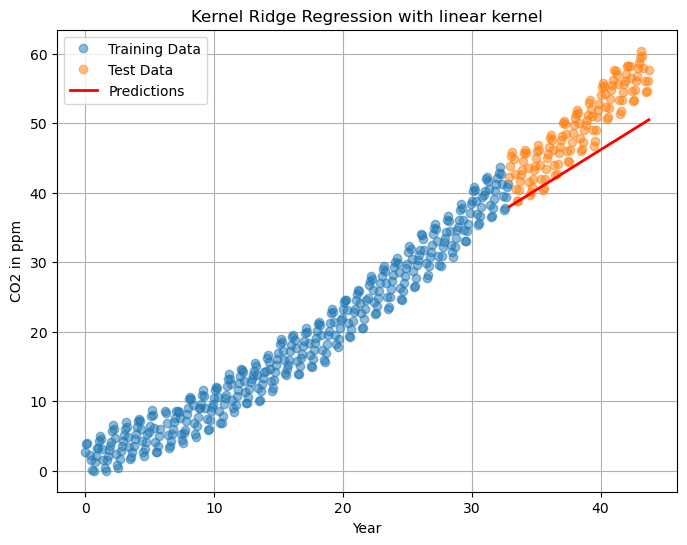

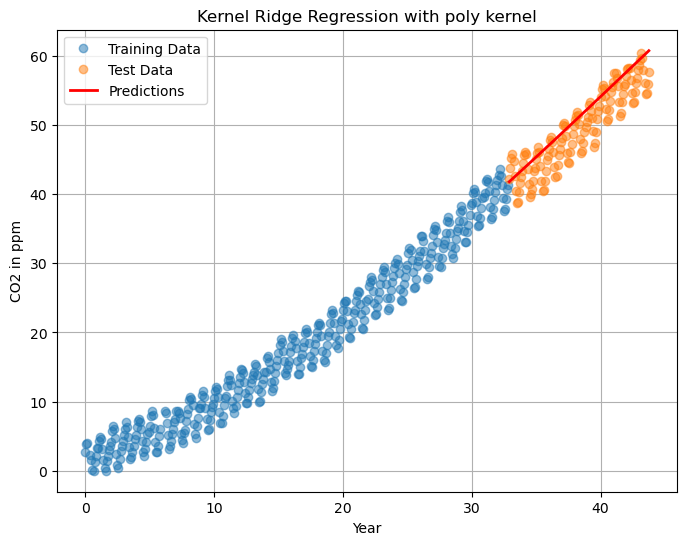

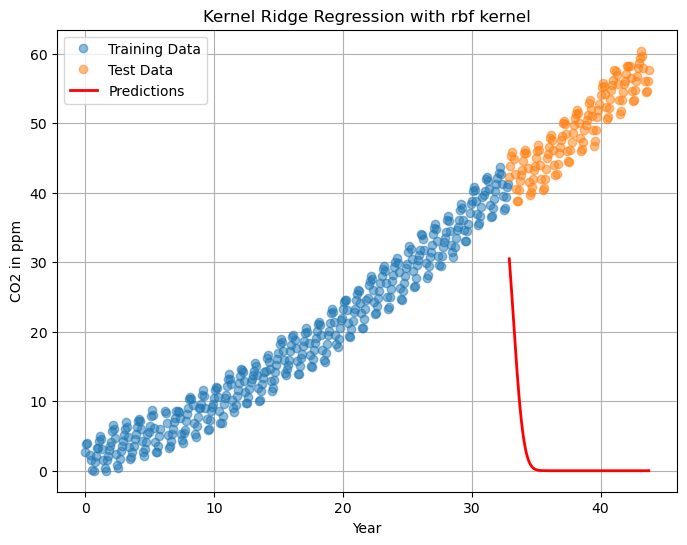

/Users/yhra/miniconda3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


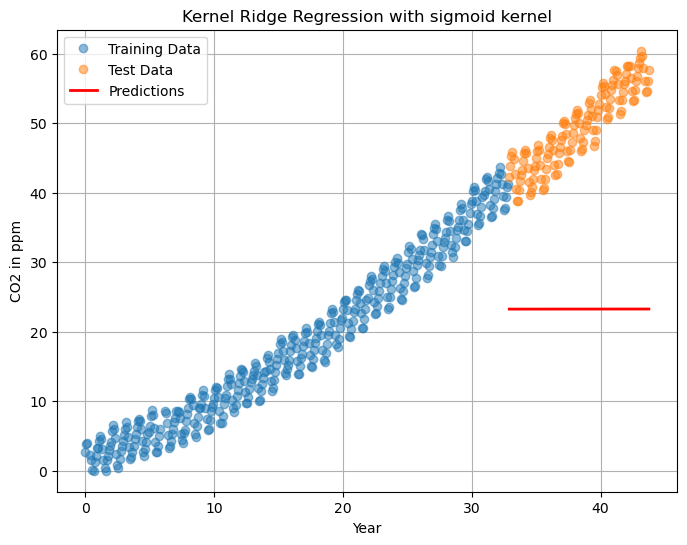

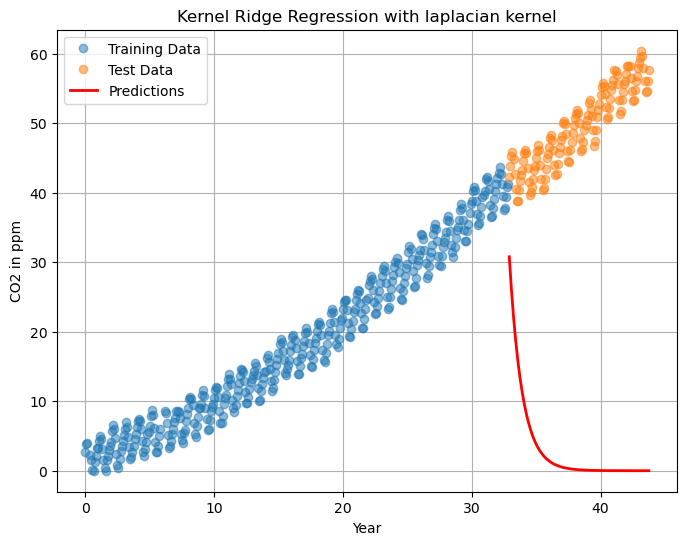


Kernel Regression Results:
--------------------------------------------------
Kernel                   MSE        R2 Score
--------------------------------------------------
linear               33.8830         -0.1008
poly                  8.6854          0.7178
rbf                2342.6240        -75.1060
sigmoid             713.6896        -22.1860
laplacian          2263.0671        -72.5214
--------------------------------------------------


In [8]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian']
from sklearn.kernel_ridge import KernelRidge
# import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
# reshape X_train and X_test
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

results = {}
for i, kernel in enumerate(kernels):
    model = KernelRidge(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Create individual plot for each kernel
    plt.figure(figsize=(8, 6))
    plt.plot(X_train, y_train, 'o', label='Training Data', alpha=0.5)
    plt.plot(X_test, y_test, 'o', label='Test Data', alpha=0.5)
    plt.plot(X_test, y_pred, 'r-', label='Predictions', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('CO2 in ppm')
    plt.title(f'Kernel Ridge Regression with {kernel} kernel')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    results[kernel] = {}
    results[kernel]['MSE'] = mean_squared_error(y_test, y_pred)
    results[kernel]['R2'] = r2_score(y_test, y_pred)

# Print results in a formatted table
print("\nKernel Regression Results:")
print("-" * 50)
print(f"{'Kernel':<12} {'MSE':>15} {'R2 Score':>15}")
print("-" * 50)
for kernel in kernels:
    print(f"{kernel:<12} {results[kernel]['MSE']:>15.4f} {results[kernel]['R2']:>15.4f}")
print("-" * 50)




## Task 2.5 Residuals anlysis

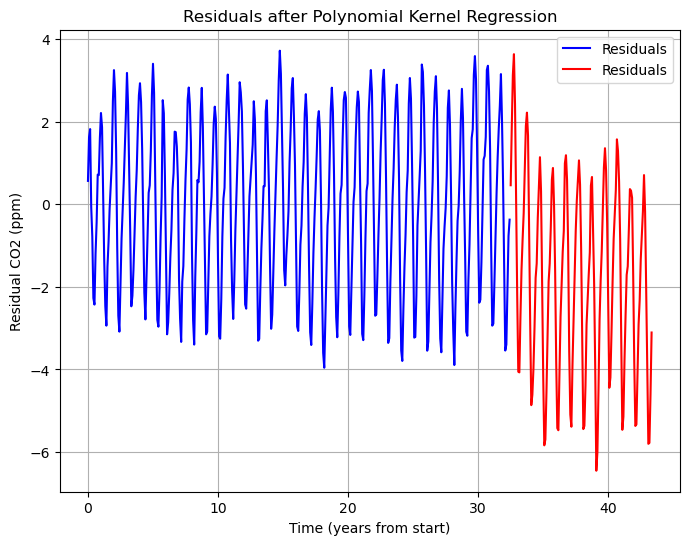

In [9]:
# Combine X_train and X_test for full timeline
X_full = np.concatenate([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

# Fit model with polynomial kernel
best_model = KernelRidge(kernel='poly', alpha=1.0)
best_model.fit(X_train, y_train)

# Get predictions for full timeline
y_pred_full = best_model.predict(X_full)

# Calculate residuals
residuals = y_full - y_pred_full

# Create timeline starting at 0
timeline = np.arange(len(residuals)) / 12  # Convert to years

# Split residuals into train/test sets (75%/25%)
split_idx = int(0.75 * len(residuals))
timeline_train = timeline[:split_idx]
timeline_test = timeline[split_idx:]
residuals_train = residuals[:split_idx]
residuals_test = residuals[split_idx:]

# Plot residuals
plt.figure(figsize=(8, 6))
plt.plot(timeline_train, residuals_train, 'b-', label='Residuals')
plt.plot(timeline_test, residuals_test, 'r-', label='Residuals')
plt.xlabel('Time (years from start)')
plt.ylabel('Residual CO2 (ppm)')
plt.title('Residuals after Polynomial Kernel Regression')
plt.legend()
plt.grid(True)
plt.show()


## Task 2.6 fit Residuals with own Kernel

In [10]:
def exp_sine_kernel(X: np.ndarray , Y: np.ndarray):
    n_data1 = X.shape [0]
    n_data2 = Y.shape [0]
    kernel_mat = np.zeros(shape=(n_data1 , n_data2))
    for idx1 in range(n_data1):
        for idx2 in range(n_data2):
            d = np.linalg.norm(X[idx1] - Y[idx2])
            value = np.exp( -2.0*np.power(np.sin(np.pi*d), 2))
            kernel_mat[idx1 , idx2] = value
    return kernel_mat

# Reshape timeline data for kernel computation
X_timeline = timeline.reshape(-1, 1)
X_timeline_train = timeline_train.reshape(-1, 1) 
X_timeline_test = timeline_test.reshape(-1, 1)

# Compute kernel matrices
K_train = exp_sine_kernel(X_timeline_train, X_timeline_train)
K_test = exp_sine_kernel(X_timeline_test, X_timeline_train)

# Create and fit model
model = KernelRidge(kernel='precomputed', alpha=1.0)
model.fit(K_train, residuals_train)

# Make predictions
residuals_pred = model.predict(K_test)

# Calculate RMSD on test set
rmsd = np.sqrt(mean_squared_error(residuals_test, residuals_pred))
print(f"RMSD on test set: {rmsd:.3f}")





RMSD on test set: 2.116


## Task 2.7 Put everything together



RMSD on full test set: 2.312


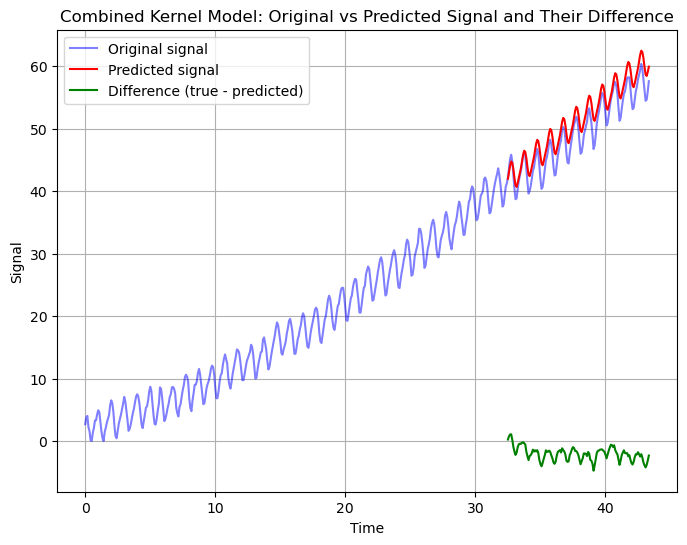

In [11]:
from sklearn.metrics.pairwise import polynomial_kernel
# Compute polynomial kernel matrices
poly_K_train = polynomial_kernel(X_timeline_train, X_timeline_train, degree=3)
poly_K_test = polynomial_kernel(X_timeline_test, X_timeline_train, degree=3)

# Add the kernel matrices together
combined_K_train = K_train + poly_K_train 
combined_K_test = K_test + poly_K_test

# Create and fit model on full signal (not just residuals)
combined_model = KernelRidge(kernel='precomputed', alpha=1.0)
combined_model.fit(combined_K_train, y_train)

# Make predictions
y_pred = combined_model.predict(combined_K_test)

# Calculate RMSD on test set for full signal
rmsd_full = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSD on full test set: {rmsd_full:.3f}")

# Plot the difference between predictions and original labels
plt.figure(figsize=(8, 6))
plt.plot(timeline, y, 'b-', label='Original signal', alpha=0.5)
plt.plot(timeline_test, y_pred, 'r-', label='Predicted signal')
plt.plot(timeline_test, y_test - y_pred, 'g-', label='Difference (true - predicted)')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Combined Kernel Model: Original vs Predicted Signal and Their Difference')
plt.legend()
plt.grid(True)
plt.show()
